In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from urllib.parse import quote_plus

# Set a clean style for the plots
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-deep")

# =========================================
# === Database Connection and Data Loading
# =========================================

# Database credentials
user = "root"
password = "Root7878"
host = "localhost"
port = 3306
database = "DataWarehouse"

# Encode password safely (important if it has special chars like @ or $)
password = quote_plus(password)

# Create SQLAlchemy engine
try:
    engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")
    
    # SQL query to get the performance analysis data
    sql_query = """
    WITH yearly_product_sales AS (
        SELECT
            YEAR(f.order_date) AS order_year,
            p.product_name,
            SUM(f.sales_amount) AS current_sales
        FROM fact_sales f
        LEFT JOIN dim_products p
        ON f.product_key = p.product_key
        WHERE f.order_date IS NOT NULL
        GROUP BY YEAR(f.order_date),
                 p.product_name
    )
    
    SELECT
        order_year,
        product_name,
        current_sales,
        AVG(current_sales) OVER (PARTITION BY product_name) AS avg_sales,
        current_sales - AVG(current_sales) OVER (PARTITION BY product_name) AS diff_in_avg,
        CASE WHEN current_sales - AVG(current_sales) OVER (PARTITION BY product_name) < 0 THEN 'Below Average'
             WHEN current_sales - AVG(current_sales) OVER (PARTITION BY product_name) >  0 THEN 'Above Average'
             ELSE 'Average'
        END avg_change,
        LAG(current_sales) OVER (PARTITION BY product_name ORDER BY order_year) prev_year_sales,
        current_sales - LAG(current_sales) OVER (PARTITION BY product_name ORDER BY order_year) AS difference_from_prev_year,
        CASE WHEN current_sales - LAG(current_sales) OVER (PARTITION BY product_name ORDER BY order_year) < 0 THEN 'Decrease'
             WHEN current_sales - LAG(current_sales) OVER (PARTITION BY product_name ORDER BY order_year) >  0 THEN 'Increase'
             ELSE 'No Change'
        END prev_year_change
    FROM yearly_product_sales
    ORDER BY product_name, order_year;
    """
    df = pd.read_sql(sql_query, engine)
    
    print("DataFrame Head:")
    print(df.head())
    print("-" * 50)
    
except Exception as e:
    print(f"Error connecting to the database or loading data: {e}")
    print("Please ensure your database credentials are correct and the database is running.")
    df = pd.DataFrame()

DataFrame Head:
   order_year            product_name  current_sales  avg_sales  diff_in_avg  \
0        2012  All-Purpose Bike Stand          159.0    13197.0     -13038.0   
1        2013  All-Purpose Bike Stand        37683.0    13197.0      24486.0   
2        2014  All-Purpose Bike Stand         1749.0    13197.0     -11448.0   
3        2012            AWC Logo Cap           72.0     6570.0      -6498.0   
4        2013            AWC Logo Cap        18891.0     6570.0      12321.0   

      avg_change  prev_year_sales  difference_from_prev_year prev_year_change  
0  Below Average              NaN                        NaN        No Change  
1  Above Average            159.0                    37524.0         Increase  
2  Below Average          37683.0                   -35934.0         Decrease  
3  Below Average              NaN                        NaN        No Change  
4  Above Average             72.0                    18819.0         Increase  
-----------------------

In [ ]:
# ================================
# === Data Visualizations
# ================================

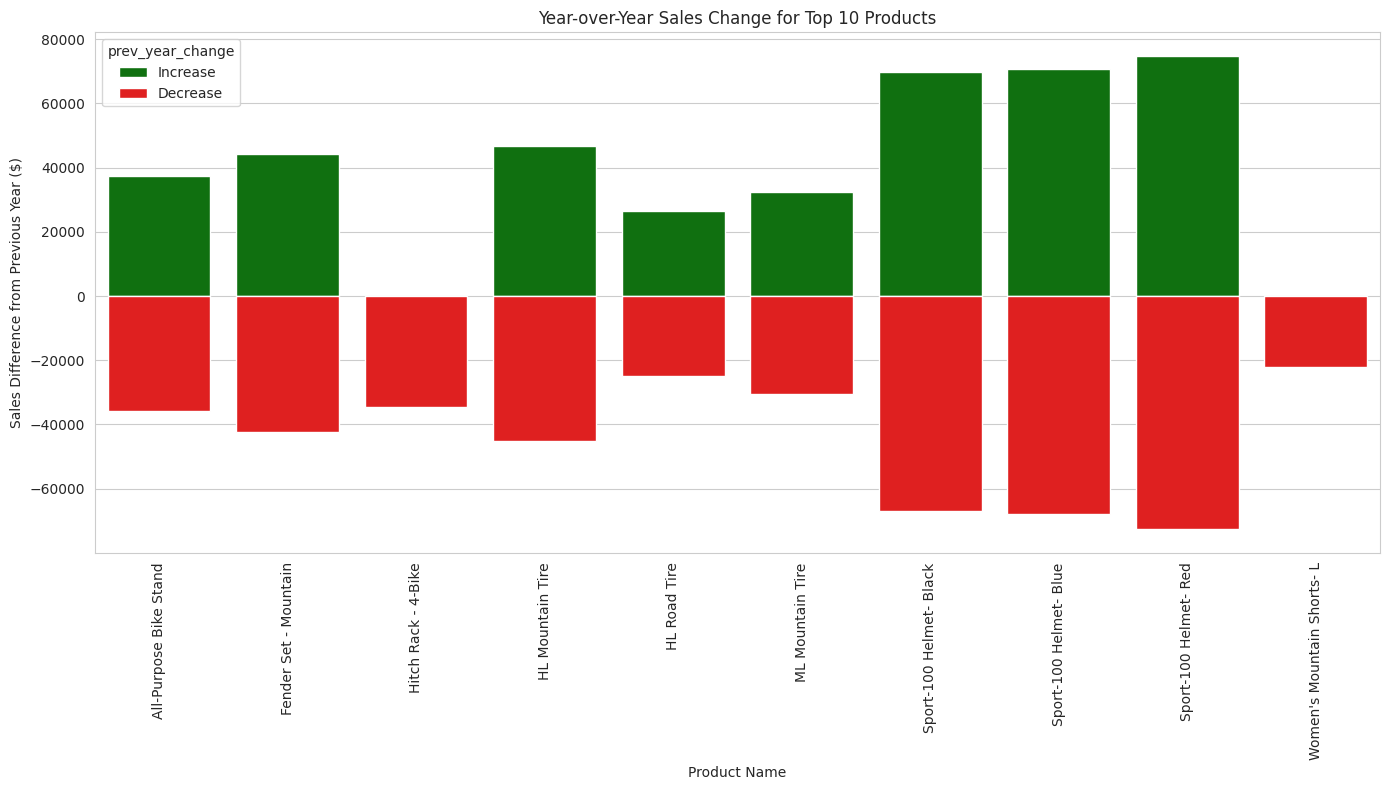

In [5]:
if not df.empty:
    
    # Get the latest year in the dataset
    latest_year = df['order_year'].max()

    # Get the top 10 products based on sales in the latest year
    top_10_products_list = df[df['order_year'] == latest_year].sort_values('current_sales', ascending=False).head(10)['product_name'].tolist()

    # Filter the DataFrame to include only the top 10 products
    df_top_10 = df[df['product_name'].isin(top_10_products_list)]

    # === 2. Deviation Bar Chart: Year-over-Year Change for Top 10 Products ===
    df_with_change = df_top_10.dropna(subset=['difference_from_prev_year'])
    if not df_with_change.empty:
        plt.figure(figsize=(14, 8))
        sns.barplot(
            data=df_with_change, 
            x='product_name', 
            y='difference_from_prev_year', 
            hue='prev_year_change', 
            palette={'Increase': 'green', 'Decrease': 'red', 'No Change': 'gray'},
            dodge=False,
            legend=True
        )
        plt.title('Year-over-Year Sales Change for Top 10 Products')
        plt.xlabel('Product Name')
        plt.ylabel('Sales Difference from Previous Year ($)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    
else:
    print("DataFrame is empty. No visualizations will be generated.")

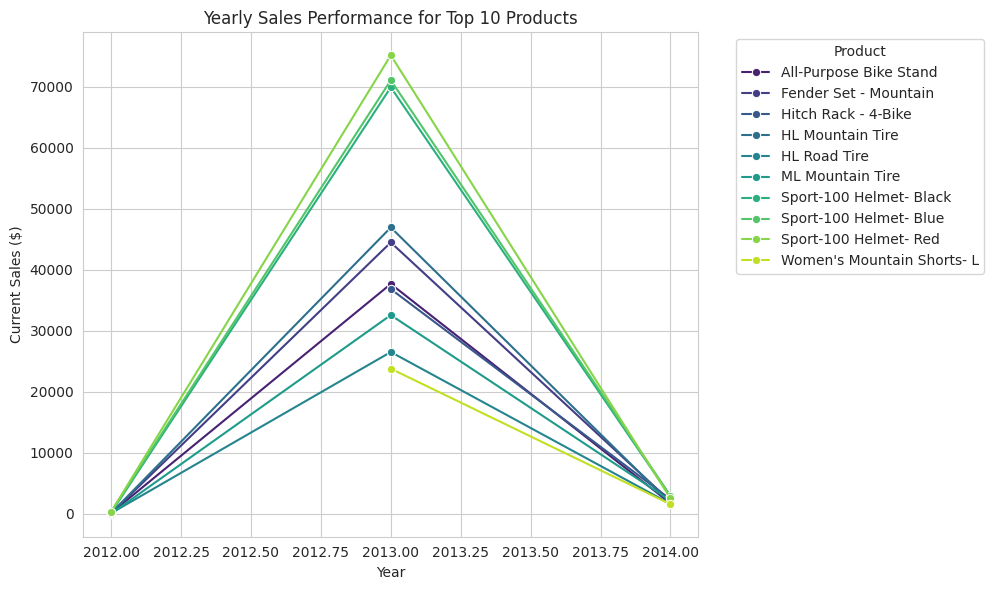

In [6]:
if not df.empty:
    
    # Get the latest year in the dataset
    latest_year = df['order_year'].max()

    # Get the top 10 products based on sales in the latest year
    top_10_products_list = df[df['order_year'] == latest_year].sort_values('current_sales', ascending=False).head(10)['product_name'].tolist()

    # Filter the DataFrame to include only the top 10 products
    df_top_10 = df[df['product_name'].isin(top_10_products_list)]

    # === 1. Dual-Axis Line Chart: Sales vs. Average Sales for Top 10 Products ===
    plt.figure(figsize=(12, 6))
    
    sns.lineplot(
        data=df_top_10, 
        x='order_year', 
        y='current_sales', 
        hue='product_name', 
        marker='o', 
        palette='viridis'
    )
    
    plt.title('Yearly Sales Performance for Top 10 Products')
    plt.xlabel('Year')
    plt.ylabel('Current Sales ($)')
    plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
    
else:
    print("DataFrame is empty. No visualizations will be generated.")

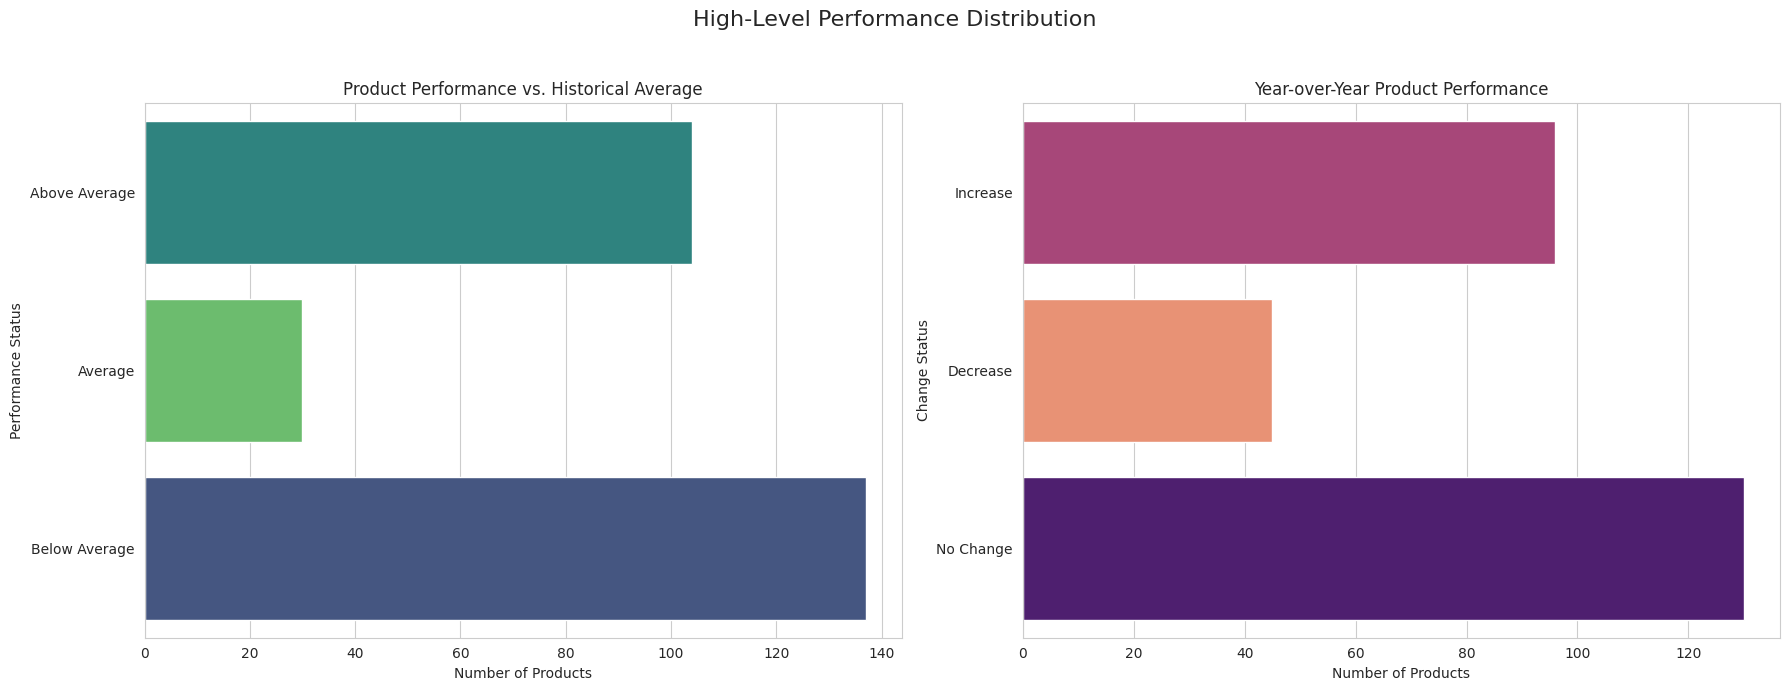

In [7]:
if not df.empty:
    
    # Get the latest year in the dataset
    latest_year = df['order_year'].max()

    # Get the top 10 products based on sales in the latest year
    top_10_products_list = df[df['order_year'] == latest_year].sort_values('current_sales', ascending=False).head(10)['product_name'].tolist()

    # Filter the DataFrame to include only the top 10 products
    df_top_10 = df[df['product_name'].isin(top_10_products_list)]

    # === 3. Performance Segment Distribution ===
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Average Change distribution
    sns.countplot(
        data=df,
        y='avg_change',
        order=['Above Average', 'Average', 'Below Average'],
        ax=axes[0],
        palette='viridis',
        hue='avg_change',
        legend=False
    )
    axes[0].set_title('Product Performance vs. Historical Average')
    axes[0].set_xlabel('Number of Products')
    axes[0].set_ylabel('Performance Status')

    # Year-over-Year Change distribution
    sns.countplot(
        data=df.dropna(subset=['prev_year_change']),
        y='prev_year_change',
        order=['Increase', 'Decrease', 'No Change'],
        ax=axes[1],
        palette='magma',
        hue='prev_year_change',
        legend=False
    )
    axes[1].set_title('Year-over-Year Product Performance')
    axes[1].set_xlabel('Number of Products')
    axes[1].set_ylabel('Change Status')

    plt.suptitle('High-Level Performance Distribution', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
else:
    print("DataFrame is empty. No visualizations will be generated.")